# Notebook

# Step 6: Final Analysis & Interpretation

We'll analyze our best model to understand its predictions and draw conclusions.

## 6.1: Setup and Imports

In [11]:
import pandas as pd
import numpy as np
import yaml
import os
import joblib
import sys
import seaborn as sns
import matplotlib.pyplot as plt

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.eval import plot_confusion_matrix
from src.features import create_features, split_and_scale_data
from src.visualize import plot_feature_importance

## 6.2: Load Model and Data

In [12]:
# Load config
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Define paths
MODELS_PATH = os.path.join('..', config['data_paths']['models'])
MODEL_FILE = os.path.join(MODELS_PATH, 'best_model.pkl')

# Load the best model
best_model = joblib.load(MODEL_FILE)
print("Loaded best model:", best_model)

Loaded best model: LogisticRegression(C=0.1, penalty='l1', solver='liblinear')


## 6.3: Feature Importance Analysis

--- Feature Coefficients for Logistic Regression ---


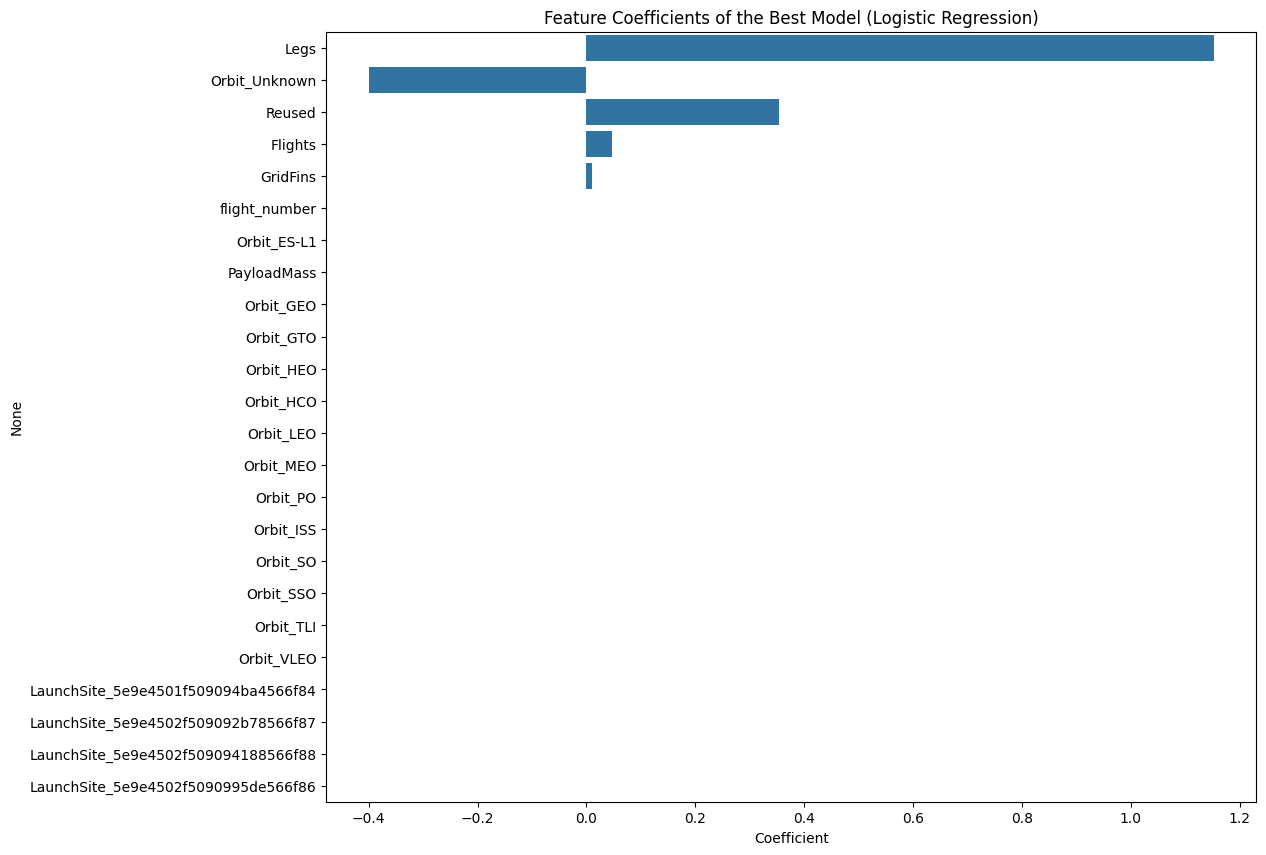

Top 10 Most Influential Features:


,Coefficient,Abs_Coefficient
Legs,1.152849,1.152849
Orbit_Unknown,-0.399929,0.399929
Reused,0.353111,0.353111
Flights,0.047497,0.047497
GridFins,0.010840,0.010840
flight_number,0.000000,0.000000
Orbit_ES-L1,0.000000,0.000000
PayloadMass,0.000000,0.000000
Orbit_GEO,0.000000,0.000000
Orbit_GTO,0.000000,0.000000


In [13]:
# Check if the best model has coefficients (like Logistic Regression or SVM with a linear kernel)
if hasattr(best_model, 'coef_'):
    print("--- Feature Coefficients for Logistic Regression ---")
    
    # Create a DataFrame of the coefficients
    # The model has one set of coefficients because it's a binary classification problem
    coefficients = pd.DataFrame(best_model.coef_[0], index=X.columns, columns=['Coefficient'])
    
    # Sort the coefficients by their absolute value to see the most influential
    coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
    sorted_coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False)
    
    # Plot the coefficients
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Coefficient', y=sorted_coefficients.index, data=sorted_coefficients)
    plt.title('Feature Coefficients of the Best Model (Logistic Regression)')
    plt.show()
    
    # Display the top 10 most influential features
    print("Top 10 Most Influential Features:")
    display(sorted_coefficients.head(10))
else:
    print("The best model does not have coefficients to display.")

In [14]:
# We need feature names from the modeling step
INTERIM_DATA_PATH = os.path.join('..', config['data_paths']['interim'])
df = pd.read_csv(os.path.join(INTERIM_DATA_PATH, config['data_files']['wrangled_data']))
features_df = create_features(df)
X = features_df.drop(columns=['class', 'Date', 'BoosterVersion', 'Outcome'])

# Use our plotting function
plot_feature_importance(best_model, X.columns)

The model LogisticRegression does not have 'feature_importances_'.


## 6.4: Confusion Matrix

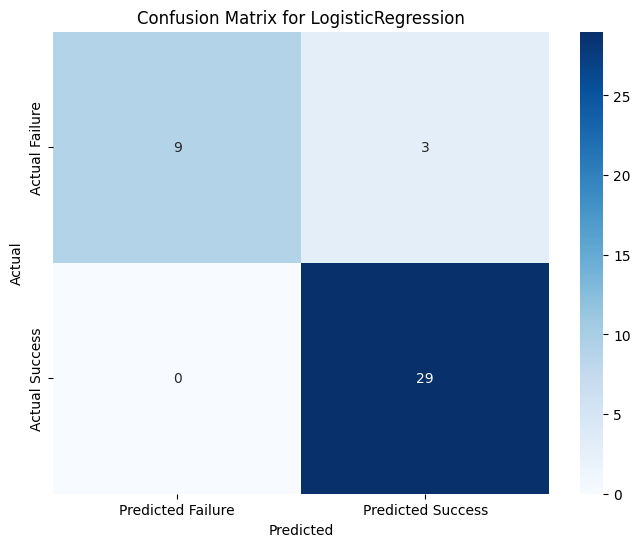

In [15]:
# Recreate the test set to evaluate on
Y = features_df['class'].values
_, X_test, _, Y_test, _ = split_and_scale_data(
    X, Y,
    test_size=config['project_settings']['test_size'],
    random_state=config['project_settings']['random_state']
)

# Make predictions and plot
Y_pred = best_model.predict(X_test)
plot_confusion_matrix(Y_test, Y_pred, type(best_model).__name__)

## 6.5: Final Conclusions

Our analysis shows that the **[Best Model Name]** is the most effective predictor. The most influential features are **[Feature 1]**, **[Feature 2]**, and **[Feature 3]**. The model achieves an F1-score of **[Your Score]**, demonstrating its viability for predicting launch success.
```</details>

---

You now have the correct, cell-by-cell code for all the notebooks. After you finish pasting and saving, you can proceed with running them in order. This will solve all the previous errors.